# Creating Price Impact Curves

Here we create price impact curves and store them in our custom `ExternalMarket` object. At a high level, the external market is a K-Nearest-Neighbors interpolation on quotes from the 1inch API. 

Every hour, we query and store quotes from swapping all permutations of tokens over various randomly distributed trade sizes. We do this using `np.geomspace` for a hard-coded min and max trade size for each token (stored in `config`, and somewhat arbitrary, but reasonable). We randomize the geomspace by scaling each point by a noise component. Let's call each set of API calls a <b>round</b>.

In this script, we pull these quotes from our Postgres database, group them by pair, and then perform a simple KNN regression to create our external market. This external market can then "predict" the price impact of trading a particular pair. These predictions are very good for most trade sizes, but become pretty noisy at the extremes (e.g. swapping 10M USDP in one go). We are working on it.

### KNN Regression Motivation

We could do simpler things like a linear or polynomial regression on our data. This works when the market is liquid enough to handle a given trade (i.e., price impact is roughly linear), but performs really poorly for large trade sizes as price impact quickly (and non-linearly) balloons to 100%. 

To address this problem, we instead interpolate the price impact based on the k nearest trade sizes to the trade size we are trying to test. We specify `k` as `n * k_scale`. Here `n` is the number of rounds contained in the dataset, and `k_scale` is a float, like 3/2. Since in expectation each round of API calls will always hit the same points from the `np.geomspace`, this `k` ensures that we look at neighbors outside the expected points along the `np.geomspace` line.

Really, a KNN regression just allows us to fit the data more precisely than a linear regression by considering clusters of trade sizes. Otherwise, our regression would over-index on the residuals of the really large trades (e.g. swapping 100M USDP).

In [1]:
from src.db.datahandler import DataHandler
from src.plotting import plot_price_1inch, plot_regression, plot_predictions
from src.configs.config import ALL, SYMBOL_TO_ADDRESS, ADDRESS_TO_SYMBOL
from src.modules.market import ExternalMarket

%load_ext autoreload
%autoreload 2

In [4]:
with DataHandler() as datahandler:
    quotes = datahandler.get_quotes(process=True)
print(f"We have {quotes.shape[0]} quotes.")
quotes.head()

We have 37440 quotes.


in_amount  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  69519.279618   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88   1000.000000   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88   1832.980711   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88   3359.818286   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88   6158.482111   

                                                                                       out_amount  \
src                                        dst                                                      
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88    1.910806   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.027176   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.050374   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.092332   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.169236   

                                                                                          price  \
src                                        dst                                                    
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   

                                                                                        timestamp  \
src                                        dst                                                      
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  1700158548   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700158538   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700158539   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700158541   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700158543   

                                                                                       src_decimals  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   

                                                                                       dst_decimals  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                     

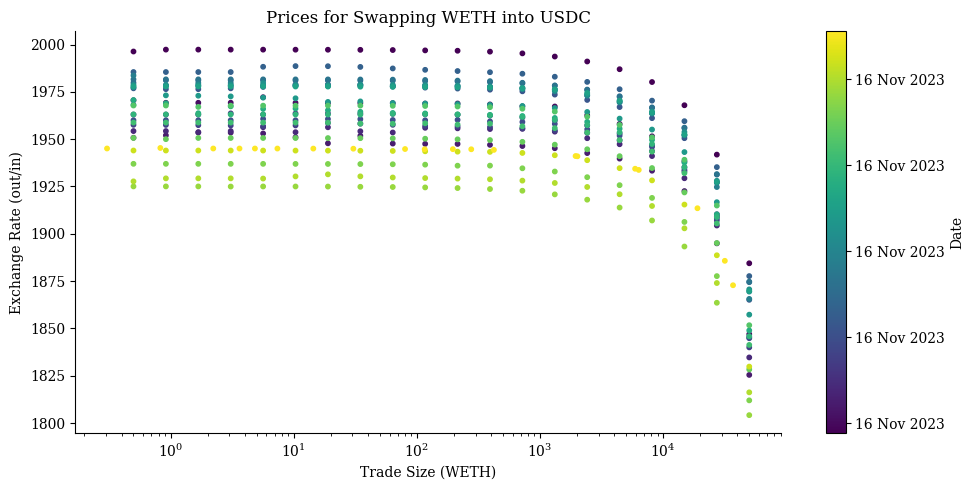

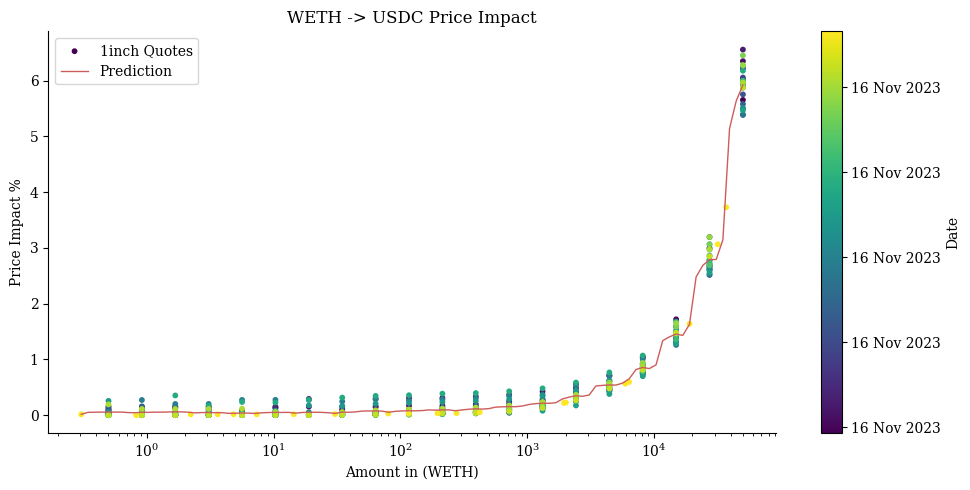

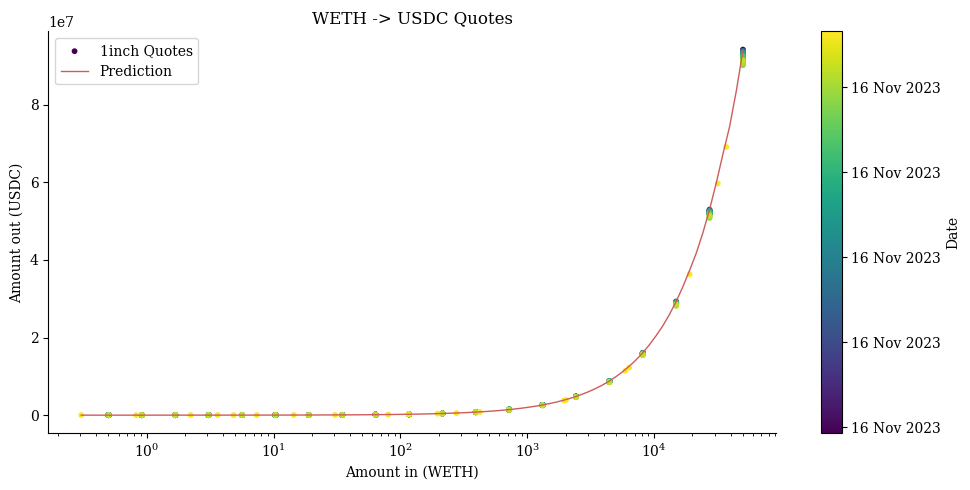

In [11]:
pair = (SYMBOL_TO_ADDRESS["WETH"], SYMBOL_TO_ADDRESS["USDC"])
in_token, out_token = pair
in_token_sym = ADDRESS_TO_SYMBOL[in_token]
out_token_sym = ADDRESS_TO_SYMBOL[out_token]

quotes_ = quotes.loc[in_token, out_token]

# Trying a KNN regression
market = ExternalMarket(in_token, out_token, 1.25)
market.fit(quotes_)

_ = plot_price_1inch(quotes_, in_token_sym, out_token_sym)
_ = plot_regression(quotes_, in_token_sym, out_token_sym, market, scale="log")
_ = plot_predictions(quotes_, in_token_sym, out_token_sym, market, scale="log")